In [72]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from qbo1d.stochastic_forcing import sample_sf_cw

from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utils

In [3]:
def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    return ax_pos_absolute

In [4]:
def plot_76_tensors(u, solver, amp25=None, amp20=None, period=None, isu=True):
    fig_size = (06.90, 02.20+01.50)
    fig = plt.figure(figsize=fig_size)

    ax = []

    ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

    cmin = -u.abs().max()
    cmax = u.abs().max()

    xmin = 84.
    xmax = 96.
    ymin = 17.
    ymax = 35.

    ax[0].set_xlim(left=84.)
    ax[0].set_xlim(right=96.)
    ax[0].set_ylim(bottom=17.)
    ax[0].set_ylim(top=35.)

    h = []

    h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

    ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
    ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

    ax[0].set_ylabel('Km', fontsize=10)

    ax[0].set_xlabel('model year', fontsize=10)

    xticks_list = np.arange(xmin, xmax+1, 1)
    ax[0].set_xticks(xticks_list)

    yticks_list = np.arange(ymin, ymax+2, 2)
    ax[0].set_yticks(yticks_list)

    xticklabels_list = list(xticks_list)
    xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
    ax[0].set_xticklabels(xticklabels_list, fontsize=10)

    ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
    ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

    ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
    ax[0].tick_params(which='both', labelbottom=True)

    if isu:
        ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %period + 'months',
        horizontalalignment='left', verticalalignment='bottom', color='black')

    # # colorbars
    if isu:
        label = r'$\mathrm{m s^{-1}}$'
    else:
        label = r'$\mathrm{m s^{-2}}$'
    
    cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
    ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
    boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
    label=label)


In [5]:
def rMSE(s_gt, s_pred):
    error = (s_gt - s_pred)
    SSE = sum(error ** 2)
    MSE = SSE/s_gt.shape[0]
    RMSE = MSE**.5
    return RMSE

def plot_MSE(RMSE_list):
    levels = list(range(len(RMSE_list[0])))
    for RMSE in RMSE_list:
        plt.scatter(x=RMSE, y=levels, s=2)
        plt.plot(RMSE, levels)
    plt.show()

# Solve the PDE using WaveSpectrum as the source function

In [6]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)

In [7]:
# calculate amplitude and period
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)

In [8]:
s = model.s

np.save('/Users/eddysmac/Desktop/QBO-Research/qbo1d/u.npy', u, allow_pickle=False)
np.save('/Users/eddysmac/Desktop/QBO-Research/qbo1d/s.npy', s, allow_pickle=False)

## Prepare for the data

### Here we only use $u$ without concatnating $sf$ and $cw$

In [95]:
u = np.load('/Users/eddysmac/Desktop/QBO-Research/qbo1d/u.npy')
s = np.load('/Users/eddysmac/Desktop/QBO-Research/qbo1d/s.npy')

In [96]:
U = u[nspinup:nsteps, :]
s = model.s
s = s[nspinup:nsteps, :]

sc_X = StandardScaler()
sc_y = StandardScaler()
U = sc_X.fit_transform(U)
s = sc_y.fit_transform(s)

# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

# Supported Vector Regression on $u$ (By sklearn)

In [98]:
svr = SVR(kernel='linear')
mr = MultiOutputRegressor(svr)
mr.fit(U_train, s_train)

MultiOutputRegressor(estimator=SVR(kernel='linear'))

In [102]:
mr.score(U_test, s_test)

0.8860770188976007

In [83]:
prediction = svr.predict(U_test)
mean_l2_loss = np.linalg.norm((sc_y.inverse_transform(prediction) - sc_y.inverse_transform(s_test)))

In [117]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

def model_ML_aug(x):
    x = x.reshape(1, 73)
    x = sc_X.transform(x)
    y = mr.predict(x)
    y = sc_y.inverse_transform(y)
    
    return torch.tensor(y[0])

u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [118]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

In [119]:
# we need to calculate s_ML for further visualization
# this step is not that trivial this time
s_ML = torch.tensor(mr.predict(u_ML))


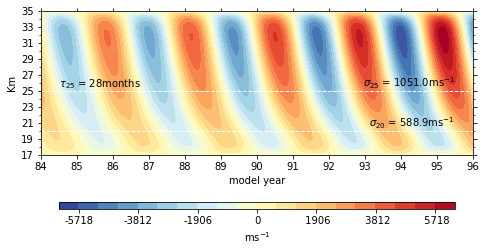

In [120]:
plot_76_tensors(u_ML, solver_ML, amp20=amp20_ML, amp25=amp25_ML, period=tau25_ML)

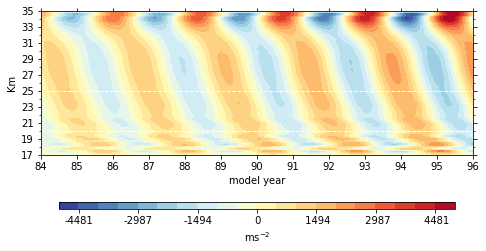

In [121]:
plot_76_tensors(s_ML, solver_ML, isu=False)